# 딥러닝(LSTM)에 의한 감정분석

# 환경설정

사람의 정서적 상태와 주관적 정보를 체계적으로 식별, 추출하는 연구

* 로지스틱 회귀 방법에 의한 분석
* 딥러닝 방법에 의한 분석

-우리가 분석하고자 하는 텍스트데이터가 있어야할것이고, 거기엔 여러가지 코맨트 내용이 저장되어있고 각 코멘트에 대해서 이것이 긍정인지 부정인지 라벨링 돼있는 데이터가 필요하다.
- 그것을 우리가 워드임베딩(센텐스임베딩)을 해줄때 참조할수 있도록 단어 사전이 필요하다. 코위키 모델을 이용해서 코위키 사전을 가지고 단어사전으로 활용할거다. 그래서 텍스트데이터를 입력할때 입력시퀀스를 얼마로할건지 n_vocab(단어사전의 길이)을 얼마로 줄건지, 코위키데이터를 사용하게되면 32007개죠? 이제 입력시퀀스는 각 한사람이 코멘트한  단어 즉, 보켑의 토큰의 수를 카운팅해서 아웃라이어만 잘라주고 나머지 길이를 맞춰준다 짧은건 패딩, 긴것은 길이에 맞도록 아웃라이어부분만 잘라낸다. 따라서 통일된 길이로 입력을 한다. 이 통일된 길이를 입력피처라고 한다. 그래서 인풋할때 n_seq 즉 입력피처수를 결정해준다.

In [1]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
# 여기까지 실행 후 "런타임 다시 시작..." 실행 (이 부분은 실행할 필요 없음)

Selecting previously unselected package fonts-nanum.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# data dir
data_dir = '/content/drive/MyDrive/data/'
os.listdir(data_dir)

['example.py',
 'test.txt',
 'kowiki',
 'corpus',
 '.ipynb_checkpoints',
 'A.txt',
 'news.txt',
 'myproject',
 'movie_comment.csv',
 'result.txt',
 'review.txt']

In [10]:
nsrs_dir = os.path.join(data_dir, "myproject")
if not os.path.isdir(nsrs_dir):
    os.makedirs(nsrs_dir)
os.listdir(nsrs_dir)

['tripadviser_review.csv']

# 1.환경 변수 설정 및 데이터 탐색

패딩 : 이제 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠습니다.

In [6]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.1 MB/s 


In [11]:
# vocab loading
import sentencepiece as spm
vocab = spm.SentencePieceProcessor()
vocab.load('/content/drive/MyDrive/data/kowiki/kowiki_32000.model')

True

In [13]:
# 구글드라이브 영화자료 불러와서 사용
df = pd.read_csv('/content/drive/MyDrive/data/movie_comment.csv', index_col=False)[['Score','Comment']]
df

,Score,Comment
0,1,대놓고 2편의 예고편....나중에 2편나올때 케이블에서 다시보면될정도...
1,6,난또 라스트제다이 스핀오프편인줄 알았네..ㅡㅡ
2,10,단순한 우주재난 영화가 아닌 '죽음과 삶'이라는 주제를 담고 있는 영화.. 최고의 ...
3,10,큰 기대 없이 지나가다가 TV에서 광고만 보고 재밌겠다 싶어서 봤는데 ㅋㅋㅋ 생각보...
4,10,'두려움은 마음을 죽인다. 두려움이 사라지면 나만 오롯이 남는다.' 이미 다음편이 ...
...,...,...
9985,2,디 오리지널은 개뿔 앞뒤 다 잘라놓고 오리지널? 오리지널 뜻 모르냐?
9986,10,보고나서도 입꼬리가 내려가질 않아요ㅎㅎ 건강한 코미디라는 말이 딱 맞는듯. 영화관에...
9987,10,소재가 독특한데 19금 유머와 함께여서 자칫 어두울 수 있는 현실이 웃음으로 잘 승...
9988,10,실화를 떠나 몰입할 수 밖에 없는 스토리.. 실감나는 배우들의 연기력.. 실화와 관...


In [14]:
# document 길이 데이터
# 다큐먼트의 길이를 왜알아볼까? n_seq 즉 입력변수(입력피처)의 수를 얼마로 할건지
# 정하기위해서.
train_length = df["Comment"].astype("str").apply(lambda x:len(vocab.encode_as_pieces(x)))
train_length.head(10)


0    26
1    20
2    25
3    44
4    29
5    14
6    14
7    59
8    16
9    18
Name: Comment, dtype: int64

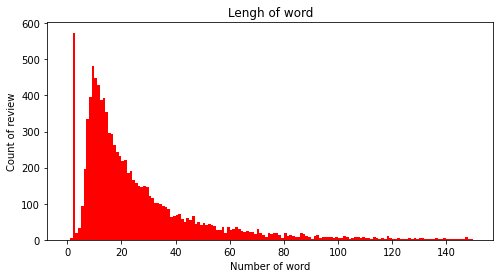

In [15]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=150, range=[0, 150], facecolor='r', label='word')
plt.title('Lengh of word')
plt.xlabel('Number of word')
plt.ylabel('Count of review')
plt.show()



In [16]:
# 데이터 길이
print(f"token 길이 최대:    {np.max(train_length):4d}")
print(f"token 길이 최소:    {np.min(train_length):4d}")
print(f"token 길이 평균:    {np.mean(train_length):7.2f}")
print(f"token 길이 표준편차: {np.std(train_length):7.2f}")

token 길이 최대:     483
token 길이 최소:       1
token 길이 평균:      27.37
token 길이 표준편차:   33.08


In [18]:
percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"token 25/100분위:  {percentile25:7.2f}")
print(f"token 50/100분위:  {percentile50:7.2f}")
print(f"token 75/100분위:  {percentile75:7.2f}")
print(f"token IQR:        {percentileIQR:7.2f}")
print(f"token MAX/100분위: {percentileMAX:7.2f}")

#해석: 댓글의 단어수가 65개 넘어가는건 아웃라이어로 지정한다. 또 짧은것은 패드로 입력해준다.

token 25/100분위:    10.00
token 50/100분위:    17.00
token 75/100분위:    32.00
token IQR:          22.00
token MAX/100분위:   65.00


In [19]:
# 앞으로 패딩입력을 위한 표준 최대 토큰수 졀정 
n_seq = 65

In [20]:
id_to_label = {0: "부정", 1: "긍정"}

In [21]:
# 점수를 기준으로 긍정(4,5)과 부정(1-3)으로 변환
def rating_to_label(rating):
    if rating > 6:
        return 1
    else:
        return 0
    
df['y'] = df['Score'].apply(lambda x: rating_to_label(x))

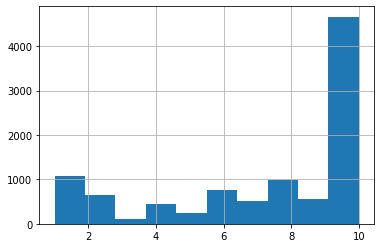

In [22]:
# 점수별 빈도수
df['Score'].hist()

# 해석: 리뷰를할땐 긍정이면 10점을주지만 9점을줄땐 뭔가 부정적인 요소가 1가지있을때
# 9점을 줄수있다. 사람마다 평가기준이 다르기때문에 이것을 긍정이냐 부정이냐 즉, 이진으로
# 나눌때는 뭔가 데이터에대한 유실이있고 또 정확한 판단이 어려운부분이 이싿.
# 따라서 그런부분을 지혜롭게 잘 정리를해야한다. 그래서 애매한 데이터는 내용을
# 읽어보고 결정해줄수있는데, 이런 방식으로(시각화) 이렇게 출력해보고 긍정부정으로 판단해주는 방법도 괜찮다.


1    6715
0    3275
Name: y, dtype: int64


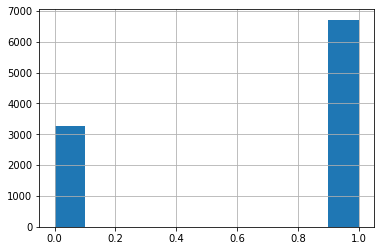

In [23]:
# 점수별 빈도수
print(df['y'].value_counts())
df['y'].hist()

# 불균형함

In [24]:
# 데이터 정리
df = df[['y', 'Comment']]
df

,y,Comment
0,0,대놓고 2편의 예고편....나중에 2편나올때 케이블에서 다시보면될정도...
1,0,난또 라스트제다이 스핀오프편인줄 알았네..ㅡㅡ
2,1,단순한 우주재난 영화가 아닌 '죽음과 삶'이라는 주제를 담고 있는 영화.. 최고의 ...
3,1,큰 기대 없이 지나가다가 TV에서 광고만 보고 재밌겠다 싶어서 봤는데 ㅋㅋㅋ 생각보...
4,1,'두려움은 마음을 죽인다. 두려움이 사라지면 나만 오롯이 남는다.' 이미 다음편이 ...
...,...,...
9985,0,디 오리지널은 개뿔 앞뒤 다 잘라놓고 오리지널? 오리지널 뜻 모르냐?
9986,1,보고나서도 입꼬리가 내려가질 않아요ㅎㅎ 건강한 코미디라는 말이 딱 맞는듯. 영화관에...
9987,1,소재가 독특한데 19금 유머와 함께여서 자칫 어두울 수 있는 현실이 웃음으로 잘 승...
9988,1,실화를 떠나 몰입할 수 밖에 없는 스토리.. 실감나는 배우들의 연기력.. 실화와 관...


# 2.Train, Test 데이터 생성

### 방안1. 기존방법

In [25]:
# 전체 데이터를 train 데이터 70%, test 데이터 30%로 분리
# 1 기존방법 df 적용,  2. undersampling으로 하면 new_df 입력 
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df, test_size = 0.3, random_state=256) # 1방안 
df_test = df_test.dropna()
df_test

# 해석: 30%가 테스트데이터로 뽑힘

,y,Comment
8659,0,"전형적으로 초반, 중반, 후반이 따로 노는 영화"
5725,0,그럭저럭. 1탄보다는 아쉽다.
1099,0,하 어라이벌 블레이드러너만 보고 바로 걸럿어야했는데 이걸 못 피했네..
8454,0,쿠키영상만 볼만함….
5444,0,연기력이 일단 바닥이고 연출력 스토리 뭐하나 제대로 된게 없는 아마추어 수준의 영화.
...,...,...
2979,1,우리가 영화를 사랑하는 이유 중 하나를 들려줬다.
7188,1,생각보다 뻔한 연출이다보니 오히려 배우들 연기력이 더 잘보이게된 케이스가 아닌가 싶...
6578,0,손에 땀을 쥐는 플롯이나 주제로 찰떡같이 귀결되는 연출 같은건 없다. 그냥 미국에사...
1914,1,그냥 너랑 봐서 좋았던 것 같다


### 방안 2.불균형문제 해결 Vs. 데이터 손실   

In [26]:
# under-sampling 방법으로 불균형 해소 : 550개 샘플만 적용하여 학습 및 평가 
positive_random_idx = df[df['y']==1].sample(3275, random_state=12).index.tolist()
negative_random_idx = df[df['y']==0].sample(3275, random_state=12).index.tolist()
random_idx = positive_random_idx + negative_random_idx
x = df['Comment'][random_idx]
y = df['y'][random_idx]
new_df = pd.concat([y,x],axis=1)
new_df

#해석: 3275개로 데이터의 균형을 맞춤.
# 그러나 딥러닝에선 많은데이터처리가 관건이기 때문에 그냥 기존방법대로
# df데이터에서 30퍼센트 데이터를 뽑는것으로 진행하겠습니다.

,y,Comment
3247,1,이해하면 굉장히 재미있는 영화!인간의 본질에 대해 생각하면 깨달음이 있고 나 자신도...
5508,1,전 개인적으론 재밌었어요. 솔직히 좀 지루함..ㅎㅎ
733,1,1초도 지루함이 없다. 미쳤다!
8148,1,NaN
6614,1,노회찬 의원님.. 그립습니다 대한민국 진보정치의 미래 이셨던분..
...,...,...
6381,0,쿠키영상을 보기위한 영화
4260,0,그냥 그랬음 칼질만 기억남
4594,0,<오징어게임>과 고교남자기숙사를 합하면?
5459,0,3년 전의 1편도 솔직히 별로였었지만 이번 2편은 역대 마블 영화들중 최악. 러닝 ...


In [27]:
# 전체 데이터를 train 데이터 70%, test 데이터 30%로 분리
# 1 기존방법 df 적용,  2. undersampling으로 하면 new_df를 입력 
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df, test_size = 0.3, random_state=256) # 2방안 

df_test = df_test.dropna()
df_test  

,y,Comment
8659,0,"전형적으로 초반, 중반, 후반이 따로 노는 영화"
5725,0,그럭저럭. 1탄보다는 아쉽다.
1099,0,하 어라이벌 블레이드러너만 보고 바로 걸럿어야했는데 이걸 못 피했네..
8454,0,쿠키영상만 볼만함….
5444,0,연기력이 일단 바닥이고 연출력 스토리 뭐하나 제대로 된게 없는 아마추어 수준의 영화.
...,...,...
2979,1,우리가 영화를 사랑하는 이유 중 하나를 들려줬다.
7188,1,생각보다 뻔한 연출이다보니 오히려 배우들 연기력이 더 잘보이게된 케이스가 아닌가 싶...
6578,0,손에 땀을 쥐는 플롯이나 주제로 찰떡같이 귀결되는 연출 같은건 없다. 그냥 미국에사...
1914,1,그냥 너랑 봐서 좋았던 것 같다


### 공통적용

In [28]:
# 1. 훈련용 데이터 정리
df_train = df_train.dropna()
df_train

,y,Comment
4700,1,가볍게 보기좋은 코믹재난영화입니다
1904,1,와 대박 간만에 ㅎㅎ 푹빠져 봤습니다
1446,0,개연성이 너무 없더라~~~
5601,1,진짜 구라 1도안섞고 개재밌음 베놈 보고오니까 확실히 느껴진다 이건 수작이다.
4187,0,정말 고구마도 이런 고구마 영화가 없다. 정말 멘탈나가게하는 답답함의 연속인 영화
...,...,...
9523,1,베놈은 베놈이네 ㅋㅋㅋ 꼭 극장에서 보시길
1776,1,무난하다...
7233,1,1편보다 재미없다 액션도 그닥
423,0,영화시작한후 10분후 그냥… 잤다… OOO


In [29]:
#3. n_seq 확인
n_seq 

65

In [30]:
# input 데이터와 라벨을 리턴해주는 함수 : 1. 입력변수 자료 데이터프레임, 2. 단어사전 vacab, 3. 토큰 최대입력 길이(패딩기준) n_seq 
# 토큰의 최대입력길이 n_seq = percentile75 + percentileIQR(percentile75 -percentile25 ) * 1.5(즉, outlier만 제거하는 수준)
from tqdm.notebook import tqdm, trange

def make_data(df, vocab, n_seq):
    inputs, labels = [], []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        label = row["y"]
        document = row["Comment"]

        token = vocab.encode_as_ids(document)
        token = token[:n_seq]
        token = token + [0] * (n_seq - len(token))
        assert len(token) == n_seq
        # print(label, len(token), token)
        inputs.append(token)
        labels.append(label)
    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [31]:
train_inputs, train_labels = make_data(df_train, vocab, n_seq)
train_inputs, train_labels

# 65개로 맞춰주기 때문에 부족한것은 0 즉, 패딩작업을 해줬다.
# array()안에 숫자는 긍정이냐 부정이냐의 데이터

  0%|          | 0/6602 [00:00<?, ?it/s]

(array([[20219,  4569, 17851, ...,     0,     0,     0],
        [   10,    25,   235, ...,     0,     0,     0],
        [  760,   344,  1409, ...,     0,     0,     0],
        ...,
        [   36,   946,   319, ...,     0,     0,     0],
        [  284,    56,   919, ...,     0,     0,     0],
        [  311,    75,   427, ...,     0,     0,     0]]),
 array([1, 1, 0, ..., 1, 0, 0]))

In [32]:
train_inputs.shape, train_labels.shape

# (6602 -> 입력데이터의 수, 65 -> 입력피처(n_seq)의 수), (전체 트레이닝데이터에 의한
# 라벨값)

((6602, 65), (6602,))

In [33]:
test_inputs, test_labels = make_data(df_test, vocab, n_seq)
test_inputs, test_labels



  0%|          | 0/2830 [00:00<?, ?it/s]

(array([[ 5665,    27,  4391, ...,     0,     0,     0],
        [   34,  7130,   651, ...,     0,     0,     0],
        [  420,   540,  3491, ...,     0,     0,     0],
        ...,
        [ 6170, 24186,    11, ...,     0,     0,     0],
        [   34,  4906,  5331, ...,     0,     0,     0],
        [   72,    60,  1996, ...,     0,     0,     0]]),
 array([0, 0, 0, ..., 0, 1, 0]))

In [34]:
test_inputs.shape, test_labels.shape

((2830, 65), (2830,))

# 3.Modeling

In [35]:
import argparse
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [36]:
args.n_vocab = len(vocab)
args.d_model = 256
args.n_out = 2
args

#해석: 모델은 256뎁스로, 아웃풋은 바이너리니까 2고 코위키의 32007, seed는 1234, n_seq는 65

Namespace(d_model=256, n_out=2, n_vocab=32007, seed=1234)

In [47]:
# 모델 정의 
import tensorflow as tf

def build_model(args):
    inputs = tf.keras.layers.Input((None,))

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden = embedding(inputs)
    
    # modeling 선택 입력 부분 : RNN, CNN, Attention, Linear 등으로 입력 
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True))
    hidden = lstm(hidden)
    # 
    #통계적추론을 위해 입력피처중 입력데이터에 대한특징적인 부분을 뽑아내기위해 맥스풀링
    pool = tf.keras.layers.GlobalMaxPooling1D() 
    hidden = pool(hidden)
    # 멕스풀링작업에서 나온 값을 softmax로 처리함 (소프트맥스는 들어온 값을 확률로 바꿔주는 함수)
    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    # 소프트맥스로 확률값을 나타냈으면 이제 예측값을 도출한다. 그 예측값으로 추론을할거에요
    y_pred = linear(hidden)

    model = tf.keras.Model(inputs=inputs, outputs=y_pred)

    return model

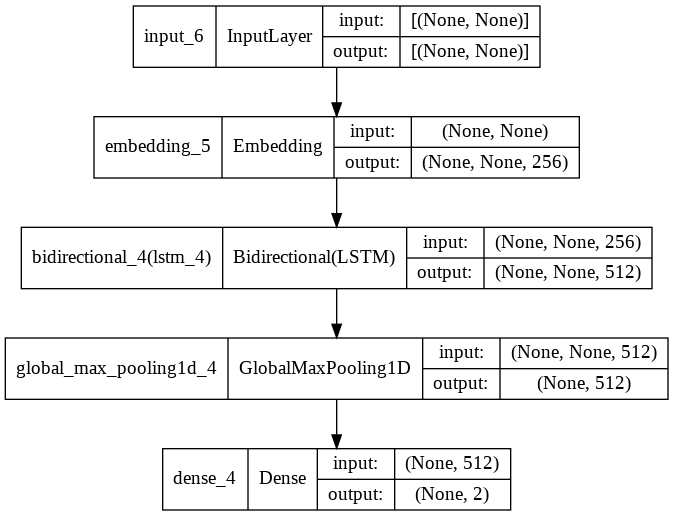

In [49]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

# input_층의 input: -> (6천개중 배치사이즈 256을 하나의 세트로 나눠서, n_seq즉 65값으로 정해질거다.)
# embedding층의 output: -> (d_model을 256으로 설정해줘서 256이 있다.) 깊이를 늘려나가는 층이다.
# 그래서 디모델링된 데이터를 가지고 lstm모델링을 통해 최종적으로 바이딕셔너리기 때문에 뎁스보다 2배가 된다.
# 2배값이 나온걸 가지고 n_seq상에서 멕스풀링을해서 가장 특징있는 부분을 추출하는 과정을 거친다.
# 입력된 6천여개의 512메트릭스를 얻는거나 마찬가지이다.
# 얻어낸 값을 가지고 이것이 부정에 가까운지 긍정에가까운지 확률값으로 우리가 2배의 값으로 내줍니다.

In [51]:
model.predict(train_inputs[:4])
# 학습이 되지않은 상태?임

array([[0.5246346 , 0.4753654 ],
       [0.52973986, 0.47026014],
       [0.52311486, 0.4768851 ],
       [0.5233752 , 0.47662476]], dtype=float32)

In [52]:
model.predict(test_inputs[:4])

array([[0.5232415 , 0.4767585 ],
       [0.5232516 , 0.47674844],
       [0.5273766 , 0.47262338],
       [0.5224091 , 0.4775909 ]], dtype=float32)

# 4.Train

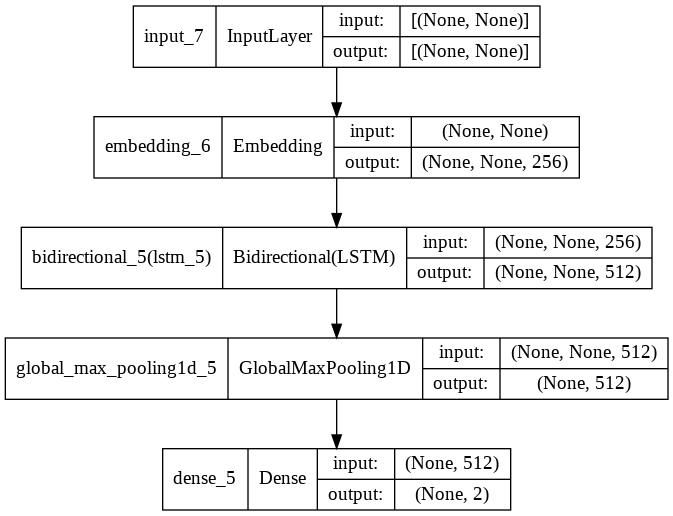

In [53]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [54]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# sparse는 원핫이 아니고 0과 1로 표기되는 트루값이 라벨링이 돼있다는것임
# 우리는 라벨링한 값이 0과1로 했고 이걸 원핫으로 코딩을하면 0은 10 1은 01으로 코딩해야하는데
# 지금우리는 0과1로 트루값을 라벨링을 넣었기때문에 sparse_categorical_crossentropy를 사용한다.

In [55]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(data_dir, 'myproject', "movie.hdf5"),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(data_dir,'myproject', "movie.csv"))

In [56]:
history = model.fit(train_inputs, train_labels,
                    epochs=100,
                    batch_size=256,
                    validation_data=(test_inputs, test_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])
# 26/26이라는것은 배치사이즈를 256이라 정해주다보니까 6천여개 데이터를
# 256개단위로 끊어주면 26개정도가 나오기 때문이다.

Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 0.6358 - accuracy: 0.6563
Epoch 00001: val_accuracy improved from -inf to 0.75477, saving model to /content/drive/MyDrive/data/myproject/movie.hdf5
26/26 [==============================] - 8s 175ms/step - loss: 0.6358 - accuracy: 0.6563 - val_loss: 0.6147 - val_accuracy: 0.7548
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.5144 - accuracy: 0.7837
Epoch 00002: val_accuracy improved from 0.75477 to 0.78551, saving model to /content/drive/MyDrive/data/myproject/movie.hdf5
26/26 [==============================] - 3s 133ms/step - loss: 0.5144 - accuracy: 0.7837 - val_loss: 0.4648 - val_accuracy: 0.7855
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.3301 - accuracy: 0.8602
Epoch 00003: val_accuracy improved from 0.78551 to 0.80035, saving model to /content/drive/MyDrive/data/myproject/movie.hdf5
26/26 [==============================] - 3s 132ms/step - loss: 0.3301 - accuracy:

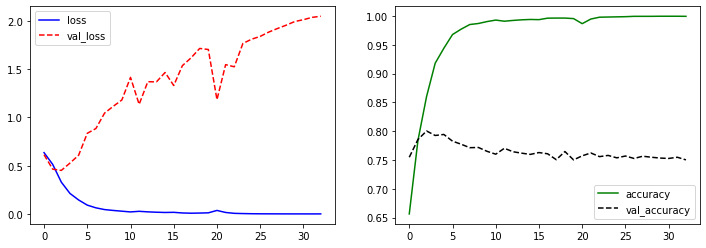

In [57]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.legend()

plt.show()

# 벨리데이션 로스가 증가함, 실제 모형에서의 로스는 감소하는것 처럼 보이지만
# 실제 우리가 테스트데이터를 적용했을때는 일정부분갔을때 이미 로스가 증가되는것을 확인할수있다
# 즉 벨리데이션 로스는 더 증가되고 벨리데이션의 아큐렛는 일정부분가면 떨어진다.
# 그래서 그 이후의 데이터는 오버피팅이 된다는 것이다. 그래서 우리는 최고값을 갖는 값을 저장해서 쓰게된다.


# 5.평가

In [58]:
model = build_model(args)
model.load_weights(os.path.join(data_dir,'myproject', "movie.hdf5"))

In [59]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [60]:
model.evaluate(test_inputs, test_labels)

89/89 [==============================] - 4s 20ms/step - loss: 0.4518 - accuracy: 0.8004


[0.4517776072025299, 0.8003533482551575]

In [61]:
y_pred = model.predict(test_inputs)
y_pred

# 각데이터에대한 예측값

array([[0.92034036, 0.0796596 ],
       [0.73831904, 0.261681  ],
       [0.36872065, 0.63127935],
       ...,
       [0.3758164 , 0.6241836 ],
       [0.46816894, 0.5318311 ],
       [0.04522556, 0.95477444]], dtype=float32)

In [62]:
y_class = np.argmax(y_pred, axis=-1)
y_class

#위에서 첫번쨰는 왼쪽이 큼 따라서 0 , 세번쨰는 오른쪽이 큼 따라서 1

array([0, 0, 1, ..., 1, 1, 1])

In [63]:
cf_matrix = np.zeros((2, 2)).astype(np.int)
cf_matrix

array([[0, 0],
       [0, 0]])

In [64]:
for y_true, y_pred in zip(test_labels, y_class):
    cf_matrix[int(y_true), int(y_pred)] += 1
cf_matrix

# 실제 예측한 값가 트루라벨을 비교해보면
# 0인것을 0으로(617) 1인것을 1으로(1648)-> 트루포지, 트루네거
# 354는 폴스포지티브(부정인데 긍정으로 잘못분류된거), 211은 폴스네거티브(긍정인데 부정으로 분류된거)

array([[ 617,  354],
       [ 211, 1648]])

In [65]:
tp = cf_matrix[1, 1]
tn = cf_matrix[0, 0]
fp = cf_matrix[0, 1]
fn = cf_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 0.1)
print(f'f1: {f1}')

accuracy: 0.8003533568904594
precision: 0.8231768231768232
recall: 0.8864981172673481
f1: 0.8536648536648537


# 6.배포

In [66]:
model = build_model(args)
model.load_weights(os.path.join(data_dir,'myproject', "movie.hdf5"))

In [67]:
string = "영화가 너무 심심해요"

In [68]:
vocab.encode_as_pieces(string)

['▁영화', '가', '▁너무', '▁심', '심', '해', '요']

In [69]:
infer_input = vocab.encode_as_ids(string)
infer_input = np.array([infer_input])
infer_input

array([[ 284,   19, 2360,  732,  690,   61,  489]])

In [70]:
train_inputs.shape, infer_input.shape

((6602, 65), (1, 7))

In [71]:
y_pred = model.predict(infer_input)
y_pred

# 부정일 확률이 더 크다.

array([[0.7119844, 0.2880156]], dtype=float32)

In [72]:
import numpy as np
y_class = np.argmax(y_pred, axis=-1)[0]
print(f"{string} : {id_to_label[y_class]}")

영화가 너무 심심해요 : 부정


In [73]:
# 위의 과정을 하나의 함수로 만든것
def do_predict(model, string):
    infer_input = vocab.encode_as_ids(string)
    infer_input = np.array([infer_input])

    y_pred = model.predict(infer_input)
    y_class = np.argmax(y_pred, axis=-1)[0]
    return id_to_label[y_class]

In [74]:
do_predict(model, string)

'부정'

In [75]:
while True:
    print("input> ", end="")
    string = str(input())
    if len(string) == 0:
        break
    result = do_predict(model, string)
    print(result)

input> 잘생겼어
긍정
input> 못생겼어
부정
input> 존나재밌어
긍정
input> 존나재밌을라다재밌지않아
긍정
input> 존나재밌지않아
긍정
input> 존나재미없어
부정
input> 개노잼
부정
input> 개꿀잼
긍정
input> 잤다
부정
input> 잠깻다
부정
input> 

KeyboardInterrupt: ignored

그래서 전체적으로 지난시간에는 텍스트데이터에 대한 신경망모델링과정을 학습했고
거기서 모델링에 lstm을 추가해서 영화데이터를 가지고 감정분석을 하는것을 해봤다.
그래서 데이터준비로부터 모델링과정 트레인, 평가, 배포까지 단계를 거치면서 했다.
여러분들도 한번 특별한데이터를 웹크롤링을통해 흭득해서 분류하는 방법을 적용하는것을 해보는것도 의미있다고 생각한다.
지금까지 학습한 여러가지 내용을 적용해서 그것을가지고 여러분것으로 만들려면 실제 이런작업을 직접해봐야한다.